In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import joblib
import itertools

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#stratified sampling trainset
X_synop_0 = X_train[X_train['SYNOPCode'] == 0]
y_synop_0_FSO = y_FSO_train[X_synop_0.index]
y_synop_0_RFL = y_RFL_train[X_synop_0.index]
# group trainset by Distance, time and Frequency
# create an empty list to save sample
sampled_X = []
sampled_y_FSO = []
sampled_y_RFL = []
#stratified sampling X
sampled_X=X_synop_0.groupby(['Distance','Frequency','Time'], group_keys=False).apply(
    lambda group:group.sample(n=min(5, len(group)), random_state=42)
)
#make Y correspond to X
sampled_y_FSO=y_synop_0_FSO.loc[sampled_X.index]
sampled_y_RFL=y_synop_0_RFL.loc[sampled_X.index]
#delete synop_0 data in the trainset
X_no_synop_0 = X_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_FSO_no_synop_0 = y_FSO_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_RFL_no_synop_0 = y_RFL_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
#merge data with deleted trainest and sampled synop_0 trainset data
X_combined = pd.concat([X_no_synop_0, sampled_X], ignore_index=True)
y_FSO_combined = pd.concat([y_FSO_no_synop_0, sampled_y_FSO], ignore_index=True)
y_RFL_combined = pd.concat([y_RFL_no_synop_0, sampled_y_RFL], ignore_index=True)
#redistribute data
combined = pd.concat([X_combined, y_FSO_combined, y_RFL_combined], axis=1)
shuffled_combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled_combined.iloc[:, :-2]
y_FSO_train = shuffled_combined.iloc[:, -2]
y_RFL_train = shuffled_combined.iloc[:, -1]

In [5]:
#define function to create interaction
def create_interaction_terms(df, interaction_vars):
    df_interactions=pd.DataFrame()
    for var in interaction_vars:
        if '*' in var:
            var1, var2 = var.split('*')
            df_interactions[var] = df[var1] * df[var2]
        else:
            df_interactions[var] = df[var]
    return df_interactions
def Generate_interaction_terms(df, features):
    interaction_data = df.copy()
    for feat1, feat2 in itertools.combinations(features, 2):
        interaction_name = f"{feat1} * {feat2}"
        interaction_data[interaction_name] = df[feat1] * df[feat2]
    return interaction_data
variables = {
    'Overall_FSO_Att': ['Time','TemperatureMin','Particulate','AbsoluteHumidity','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['Visibility','RainIntensityMin','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity']
}

In [6]:
#Prepare RFL trainset for FSO-RFL hybrid model
X_train_fso=create_interaction_terms(X_train,variables['Overall_FSO_Att'])
X_test_fso=create_interaction_terms(X_test,variables['Overall_FSO_Att'])
overall_fso=joblib.load('Overall_FSO_Att.joblib')
#Fitting FSO model
FSO_pred=overall_fso.predict(X_train_fso)
FSO_test_pred=overall_fso.predict(X_test_fso)
print(FSO_pred.shape)
#add FSO_pred into RFL trainset
X_train_RFL=X_train.copy()
X_train_RFL['FSO_pred']=FSO_pred
print(X_train_RFL)


(73103,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             19.409466            19.821508            19.071026   
1              4.735022             5.149081             4.310300   
2              3.278151             3.569293             3.164491   
3              6.117897             6.422243             5.759406   
4              6.007126             6.422619             5.765845   
...                 ...                  ...                  ...   
73098         18.785538            19.340281            18.379211   
73099          6.020335             6.585386             5.826840   
73100         10.688433            10.839295             9.810153   
73101          9.902738             9.936302             8.954657   
73102         16.553406            17.358941            15.898162   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2960.774271  83500000000     0.000000        0.000000        0.000000   
1 

In [7]:
#Prepare FSO trainset for RFL-FSO hybrid model
X_train_rfl=create_interaction_terms(X_train,variables['Overall_RFL_Att'])
X_test_rfl=create_interaction_terms(X_test,variables['Overall_RFL_Att'])
overall_rfl=joblib.load('Overall_RFL_Att.joblib')
#Fitting RFL model
RFL_pred=overall_rfl.predict(X_train_rfl)
RFL_test_pred=overall_rfl.predict(X_test_rfl)
print(RFL_pred.shape)
#add RFL_pred into FSO trainset
X_train_FSO=X_train.copy()
X_train_FSO['RFL_pred']=RFL_pred
print(X_train_FSO)

(73103,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
0             19.409466            19.821508            19.071026   
1              4.735022             5.149081             4.310300   
2              3.278151             3.569293             3.164491   
3              6.117897             6.422243             5.759406   
4              6.007126             6.422619             5.765845   
...                 ...                  ...                  ...   
73098         18.785538            19.340281            18.379211   
73099          6.020335             6.585386             5.826840   
73100         10.688433            10.839295             9.810153   
73101          9.902738             9.936302             8.954657   
73102         16.553406            17.358941            15.898162   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
0      2960.774271  83500000000     0.000000        0.000000        0.000000   
1 

In [8]:
#Variables
variables_rf_2={
    'RFL_Att_rf_2':['FSO_pred','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity'],
    'FSO_Att_rf_2':['Time','TemperatureMin','AbsoluteHumidity','Particulate','RFL_pred','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance']
}

In [9]:
# #define feature selection function
def fs(trainX, trainy, testX, testy):
    model=RandomForestRegressor(n_estimators=100,random_state=1874845,oob_score=True)
    model.fit(trainX,trainy)
    y_pred=model.predict(testX)
    return y_pred,model

In [10]:
#define plot function
def plot_results(results,Type):
    # Extract data from result_RFL
    features = results['feature']
    rmse_values = results['RMSE']
    r2_values = results['R2_score']

    # Create the figure and subplots
    fig,ax1 = plt.subplots( figsize=(10, 6), sharex=False)

    # Plotting result
    ax1.plot(features, rmse_values, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features',fontsize=14)
    ax1.set_ylabel('RMSE', color='blue',fontsize=14)
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features, r2_values, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red',fontsize=14)
    ax1_twin.tick_params(axis='y', colors='red')
    if Type=='RFL':
        ax1.set_title('RFL model Feature Importance Analysis',fontsize=14)
    else:
        ax1.set_title('FSO model Feature Importance Analysis',fontsize=14)
    plt.tight_layout()

    # Show the combined plot
    plt.show()

In [11]:
def process(Type):
    if Type=='RFL':
        fso_test_pred=overall_fso.predict(create_interaction_terms(X_test,variables['Overall_FSO_Att']))
        X_RFL_test=X_test.copy()   
        X_RFL_test['FSO_pred']=fso_test_pred
        X_train_rfl=create_interaction_terms(X_train_RFL,variables_rf_2['RFL_Att_rf_2'])
        X_rfl_test=create_interaction_terms(X_RFL_test,variables_rf_2['RFL_Att_rf_2'])
        y_pred,model = fs(X_train_rfl, y_RFL_train, X_rfl_test, y_RFL_test)
        return y_pred,model
    else:
        rfl_test_pred=overall_rfl.predict(create_interaction_terms(X_test,variables['Overall_RFL_Att']))
        X_FSO_test=X_test.copy()   
        X_FSO_test['RFL_pred']=rfl_test_pred
        X_train_fso=create_interaction_terms(X_train_FSO,variables_rf_2['FSO_Att_rf_2'])
        X_fso_test=create_interaction_terms(X_FSO_test,variables_rf_2['FSO_Att_rf_2'])
        y_pred,model = fs(X_train_fso, y_FSO_train, X_fso_test, y_FSO_test)
        return y_pred,model

In [12]:
y_pred_RFL,rf_2_RFL=process('RFL')

In [13]:
y_pred_FSO,rf_2_FSO=process('FSO')

In [14]:

y_pred_RFL_df = pd.DataFrame(y_pred_RFL, columns=['y_pred_RFL'])
y_pred_FSO_df = pd.DataFrame(y_pred_FSO, columns=['y_pred_FSO'])
FSO_pred_df = pd.DataFrame(FSO_pred, columns=['FSO_pred'])
RFL_pred_df = pd.DataFrame(RFL_pred, columns=['RFL_pred'])

y_pred_RFL_df.to_csv('y_pred_RFL_rf2.csv')
y_pred_FSO_df.to_csv('y_pred_FSO_rf2.csv')
FSO_pred_df.to_csv('y_pred_FSO_rf1.csv')
RFL_pred_df.to_csv('y_pred_RFL_rf1.csv')
y_FSO_test.to_csv('y_FSO_test.csv')
y_RFL_test.to_csv('y_RFL_test.csv')

In [15]:
results = pd.DataFrame({
    'SYNOPCode': X_test['SYNOPCode'],
    'y_pred_FSO_2': y_pred_FSO,
    'y_pred_RFL_2': y_pred_RFL,
    'FSO_pred_1': FSO_test_pred,
    'RFL_pred_1': RFL_test_pred,
    'y_FSO_test': y_FSO_test,
    'y_RFL_test': y_RFL_test
})
print(results)

       SYNOPCode  y_pred_FSO_2  y_pred_RFL_2  FSO_pred_1  RFL_pred_1  \
68601          6     14.173463     21.792282   13.433945   21.755400   
68115          0      4.504766     12.023958    4.544843   12.082300   
28357          0      2.952875     11.178258    2.918736   11.193508   
17893          0      6.369608      7.076191    6.309715    7.081080   
60284          5     11.023662     13.078878   10.429855   13.149293   
...          ...           ...           ...         ...         ...   
66872          0      6.604702     11.879629    6.677474   11.994519   
88377          0      9.726135     10.845485    9.506762   10.944630   
42756          0      2.516222     11.328391    2.597563   11.248912   
7730           5     11.036377      9.880731   10.390426    9.299820   
41634          0      2.728650     11.321684    2.760481   11.478605   

       y_FSO_test  y_RFL_test  
68601   13.077835   22.047411  
68115    4.450609   12.125053  
28357    2.890493   10.979996  
17893  

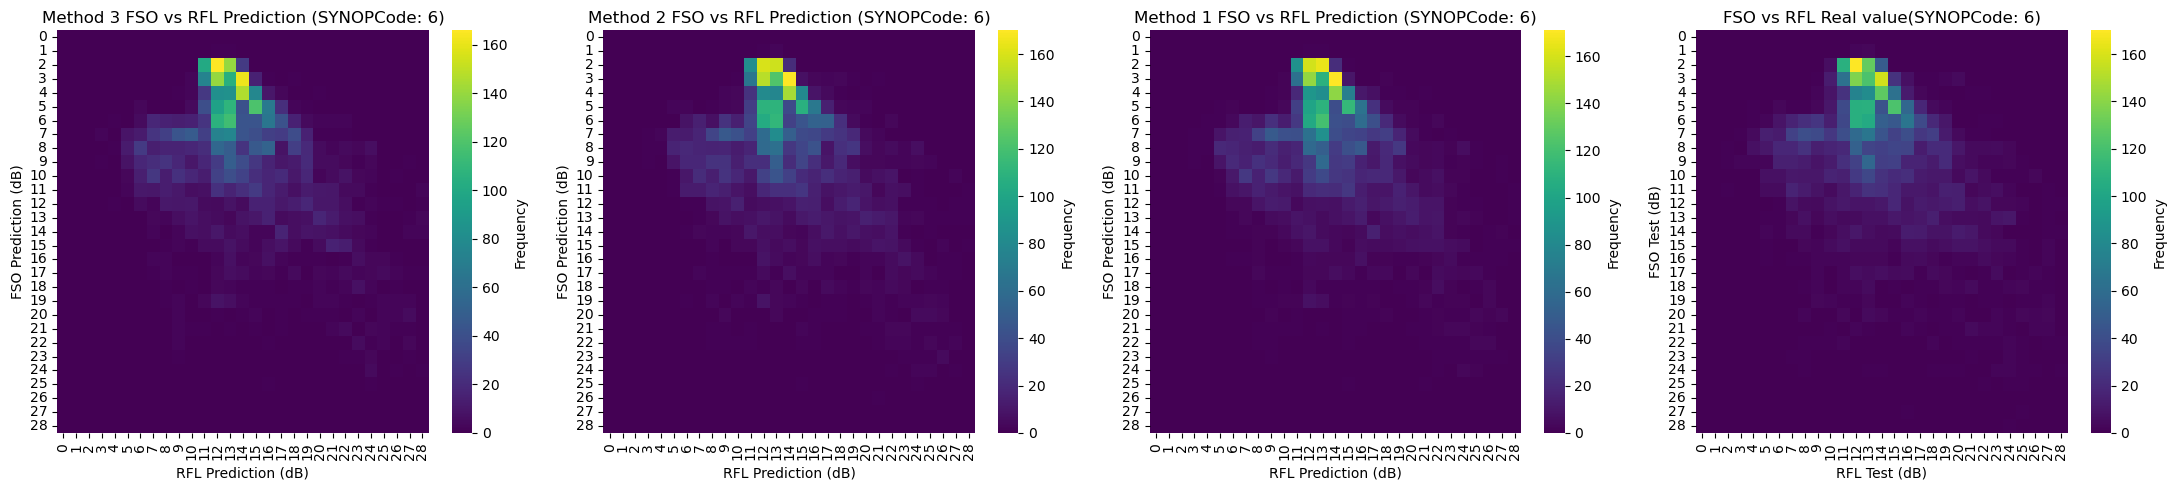

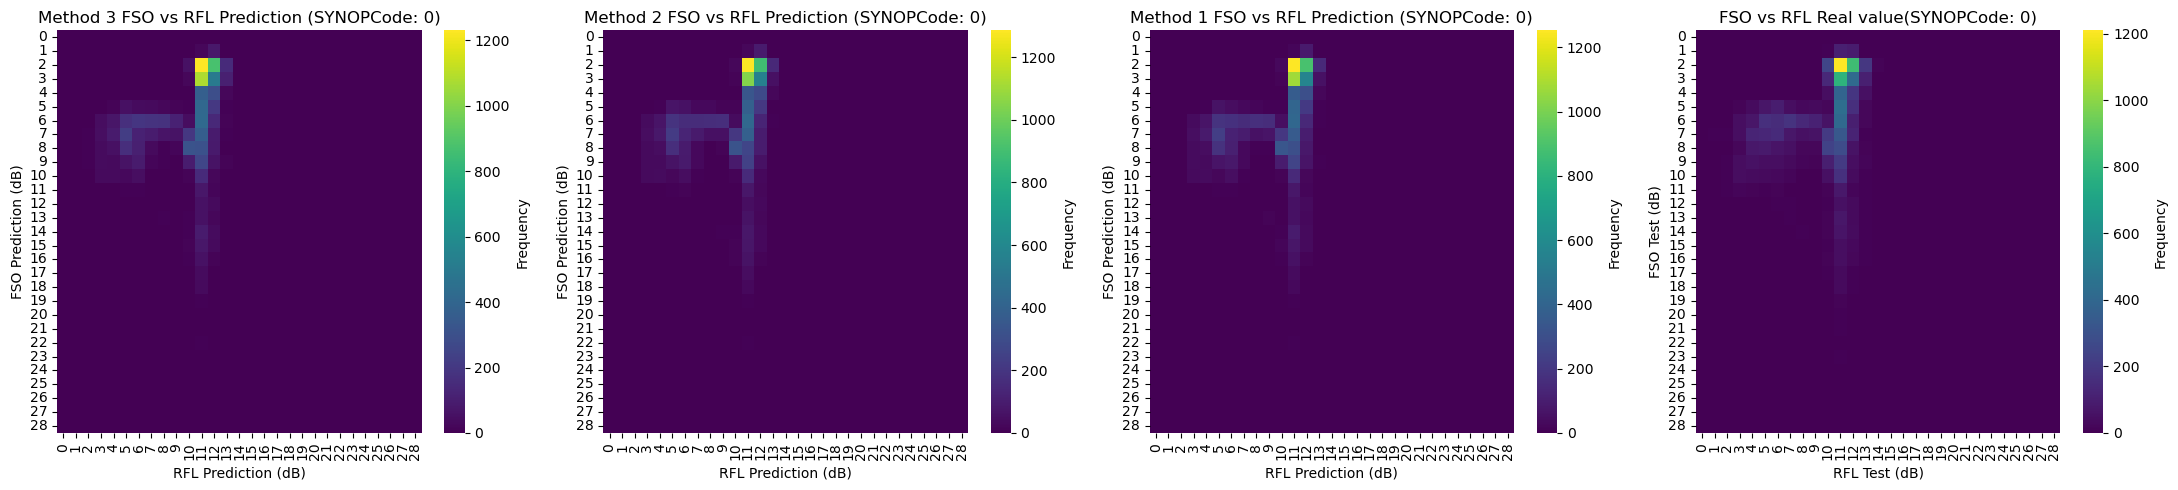

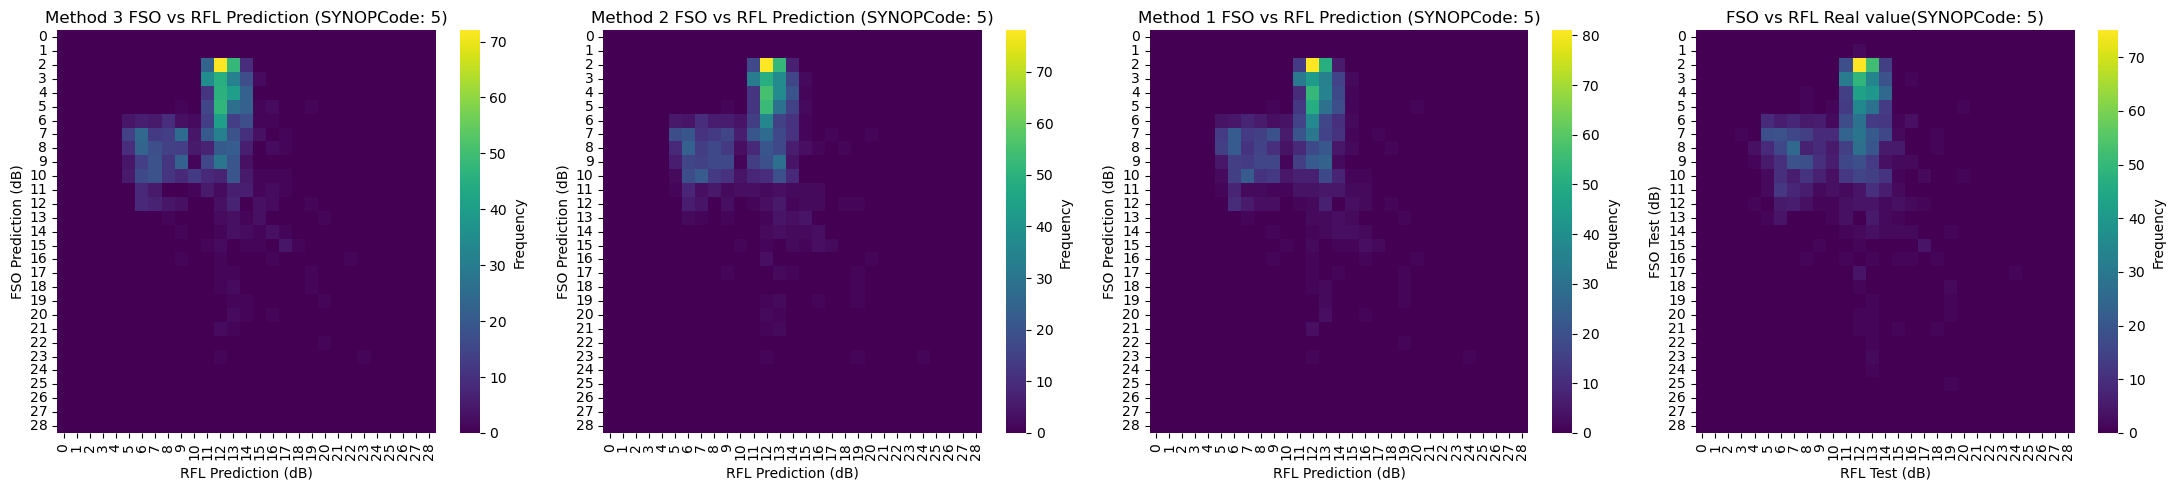

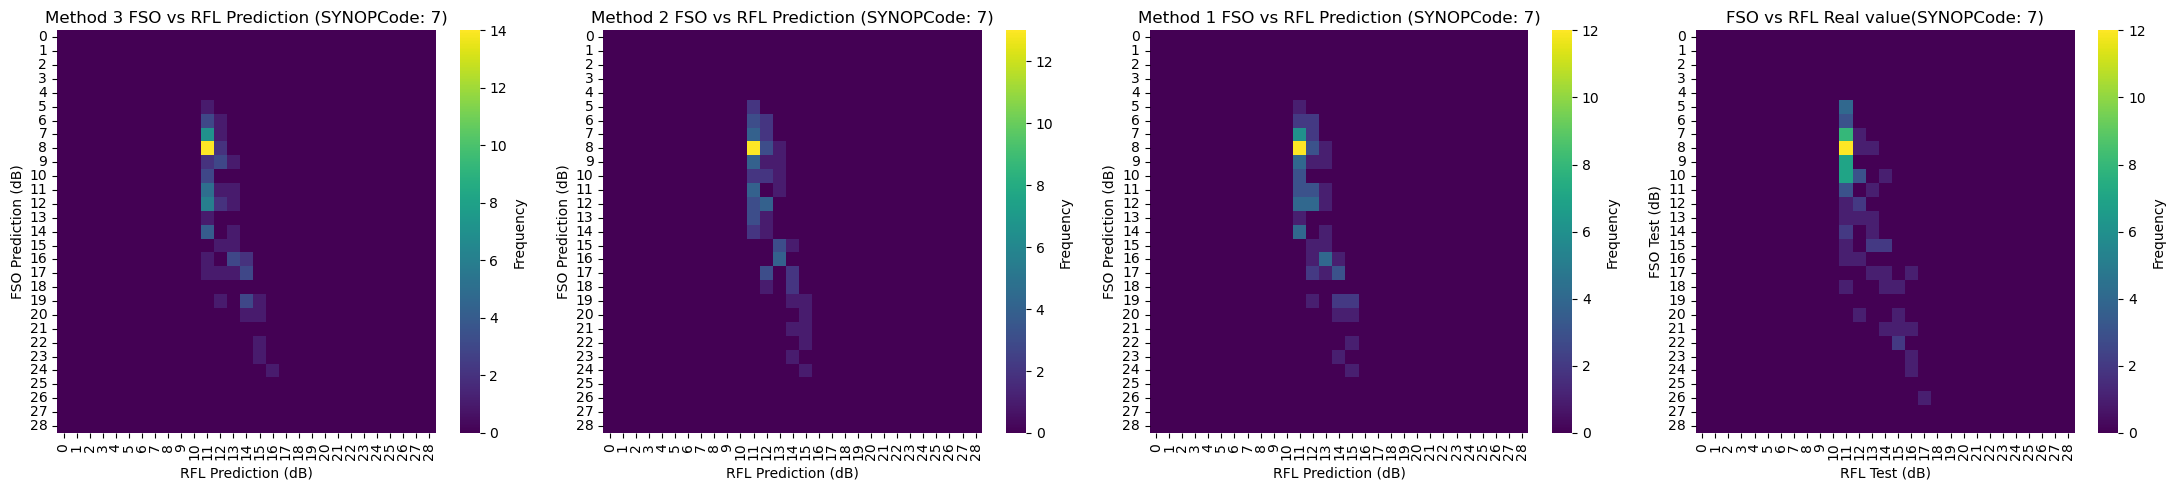

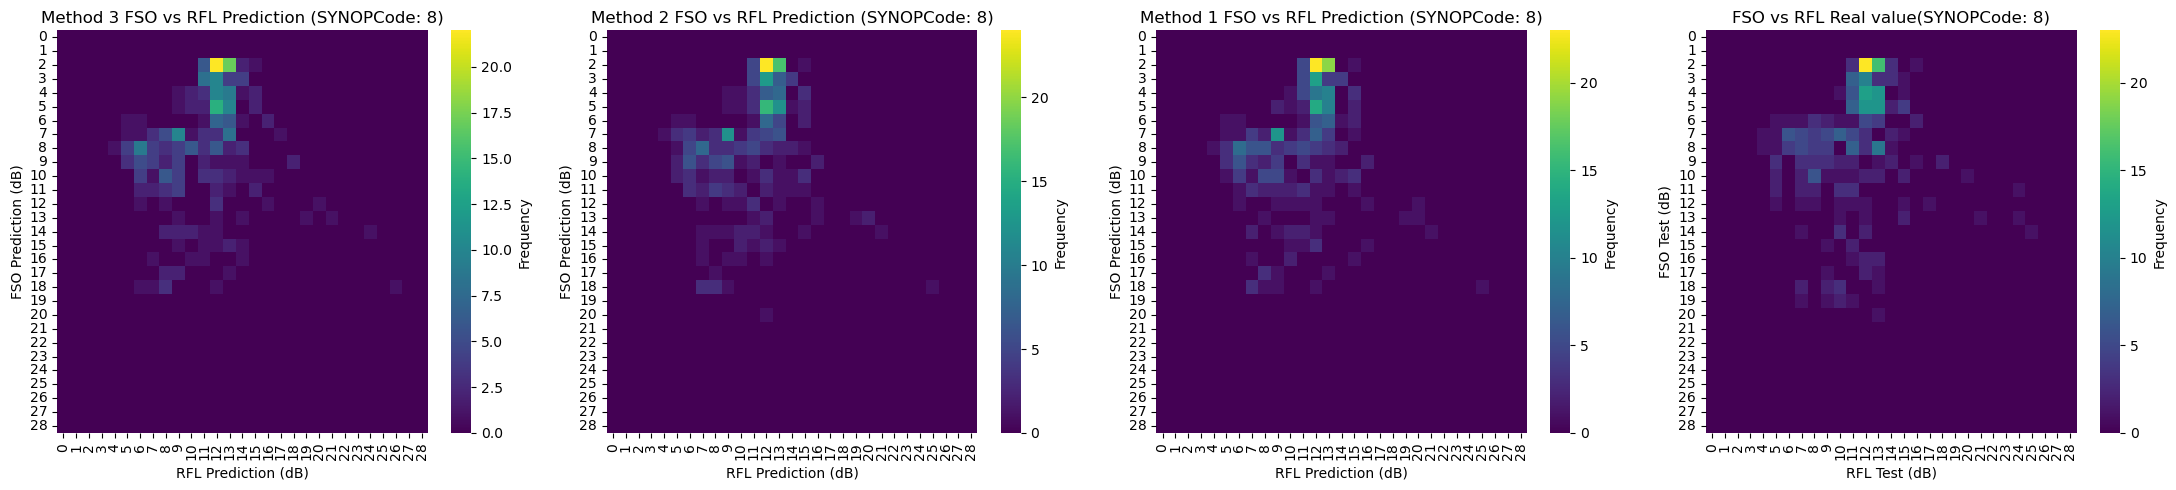

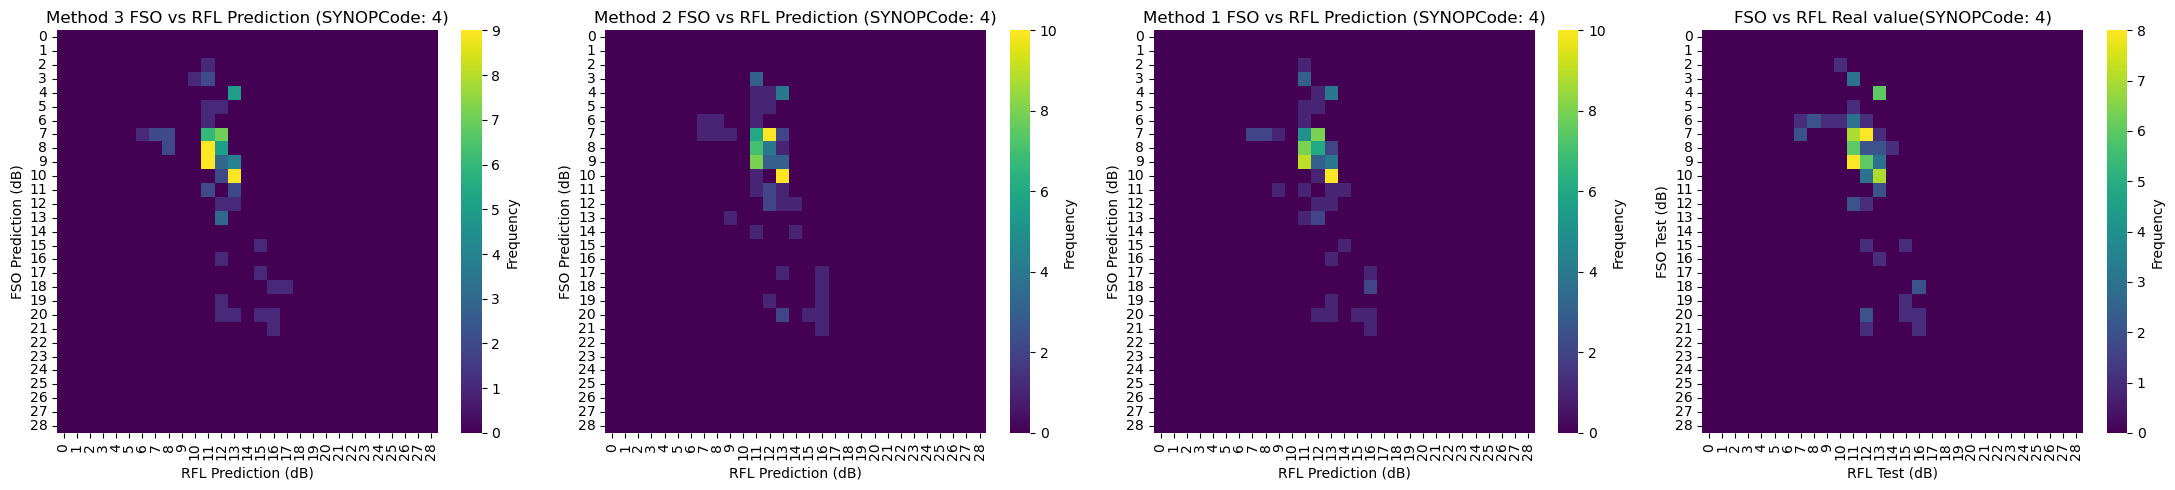

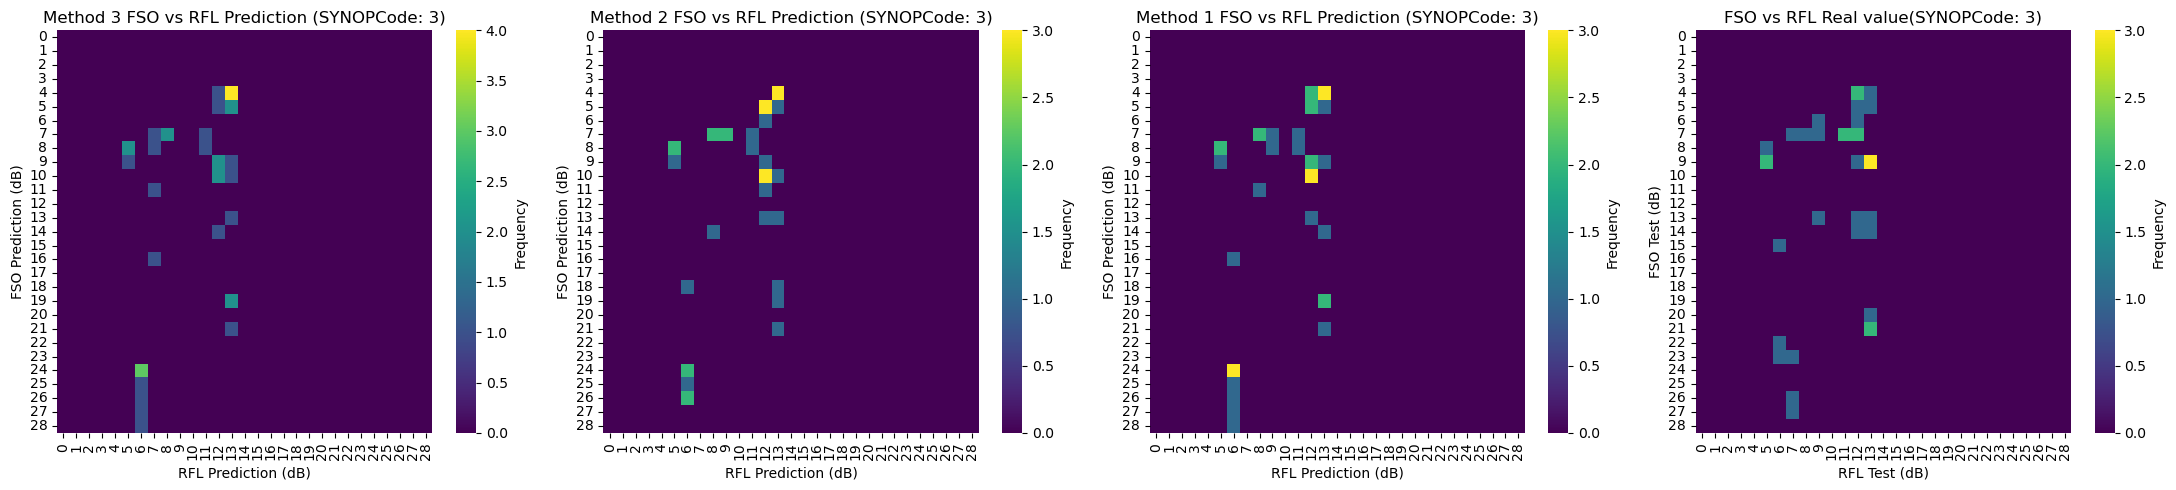

In [16]:
#generating heat map
#bin size
bin_size = 1
bins_fso = np.arange(0, 30, bin_size) 
bins_rfl = np.arange(0, 30, bin_size)  
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5), sharex=False, sharey=False)
    h_data_3, x3, y3 = np.histogram2d(
        subset['y_pred_RFL_2'], 
        subset['FSO_pred_1'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_3.T,
        xticklabels=np.round(x3[:-1], 1),
        yticklabels=np.round(y3[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax1
    )
    ax1.set_title(f'Method 3 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax1.set_xlabel('RFL Prediction (dB)')
    ax1.set_ylabel('FSO Prediction (dB)')

    h_data_2, x2, y2 = np.histogram2d(
        subset['RFL_pred_1'],  
        subset['y_pred_FSO_2'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_2.T,
        xticklabels=np.round(x2[:-1], 1),
        yticklabels=np.round(y2[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax2
    )
    ax2.set_title(f'Method 2 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax2.set_xlabel('RFL Prediction (dB)')
    ax2.set_ylabel('FSO Prediction (dB)')

    h_data_1, x1, y1 = np.histogram2d(
        subset['RFL_pred_1'], 
        subset['FSO_pred_1'],
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_1.T,
        xticklabels=np.round(x1[:-1], 1),
        yticklabels=np.round(y1[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax3
    )
    ax3.set_title(f'Method 1 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax3.set_xlabel('RFL Prediction (dB)')
    ax3.set_ylabel('FSO Prediction (dB)')

    h_data, x, y = np.histogram2d(
        subset['y_RFL_test'],
        subset['y_FSO_test'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data.T,
        xticklabels=np.round(x[:-1], 1),
        yticklabels=np.round(y[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax4
    )
    ax4.set_title(f'FSO vs RFL Real value(SYNOPCode: {synop_code})')
    ax4.set_xlabel('RFL Test (dB)')
    ax4.set_ylabel('FSO Test (dB)')

    plt.tight_layout()
    plt.show()

In [17]:
#calculate pearson corelation coefficient for method 3
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['y_pred_RFL_2']
    fso_values = subset['FSO_pred_1']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['y_pred_RFL_2'], results['FSO_pred_1'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for method 2
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_pred_1']
    fso_values = subset['y_pred_FSO_2']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['RFL_pred_1'], results['y_pred_FSO_2'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for method 1
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_pred_1']
    fso_values = subset['FSO_pred_1']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['RFL_pred_1'], results['FSO_pred_1'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for real value
pearson_results = {}
for synop_code in df['SYNOPCode'].unique():
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_Att']
    fso_values = subset['FSO_Att']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(df['RFL_Att'], df['FSO_Att'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

  SYNOPCode  Pearson_Correlation
0         6             0.365255
1         0            -0.298050
2         5            -0.160619
3         7             0.803850
4         8            -0.222653
5         4             0.581302
6         3            -0.488543
7   Overall             0.092459
  SYNOPCode  Pearson_Correlation
0         6             0.357230
1         0            -0.295247
2         5            -0.171169
3         7             0.794003
4         8            -0.258837
5         4             0.558998
6         3            -0.539909
7   Overall             0.090299
  SYNOPCode  Pearson_Correlation
0         6             0.353200
1         0            -0.298729
2         5            -0.173676
3         7             0.790903
4         8            -0.255201
5         4             0.577213
6         3            -0.523643
7   Overall             0.087873
  SYNOPCode  Pearson_Correlation
0         0            -0.267705
1         6             0.348307
2         

In [18]:
#calculate pearson corelation coefficient for real value in complete dataset
pearson_results = {}
for synop_code in df['SYNOPCode'].unique():
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_Att']
    fso_values = subset['FSO_Att']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(df['RFL_Att'], df['FSO_Att'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

  SYNOPCode  Pearson_Correlation
0         0            -0.267705
1         6             0.348307
2         8            -0.169827
3         5            -0.155631
4         3            -0.424294
5         4             0.577887
6         7             0.804480
7   Overall             0.089866


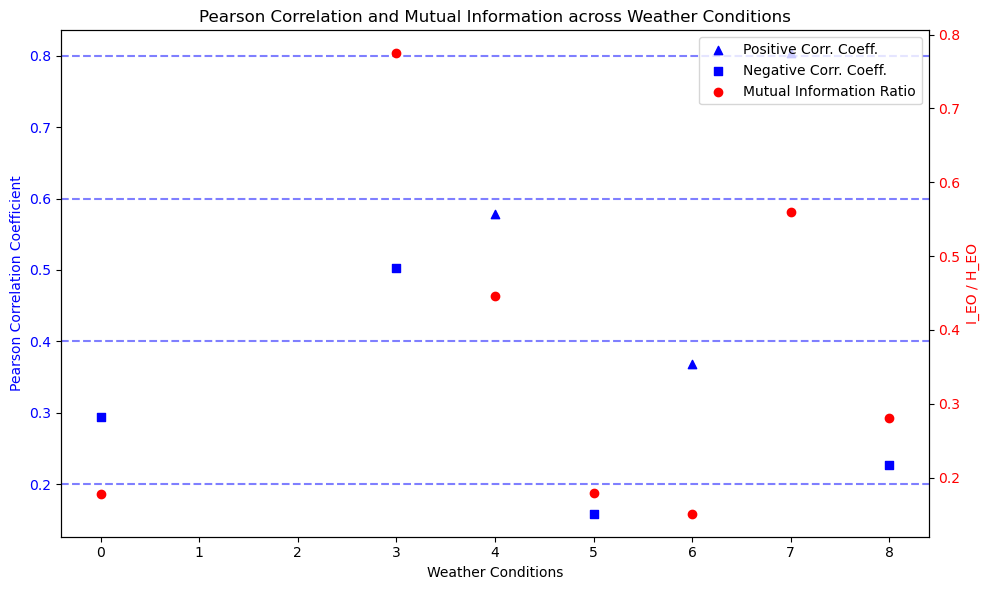

In [ ]:
#generate graph for both pearson and mutual imformation/ joint entrophy

from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score

weather_conditions = results['SYNOPCode'].unique()
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

for synop_code in weather_conditions:
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['y_pred_FSO_2']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    #mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  # 自己的熵
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

#plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# scatter plot for pearson
ax1.scatter(weather_conditions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(weather_conditions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions')
ax1.set_ylabel('Pearson Correlation Coefficient', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5)

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(weather_conditions, mutual_info_ratios, c='red', marker='o', label='Mutual Information Ratio')
ax2.set_ylabel('I_EO / H_EO', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.title('Correlation factors across Weather Conditions for RFL-FSO Hybrid model')
plt.tight_layout()
plt.show()

   SYNOPCode  RFL-FSO_RMSE  RFL-FSO_R²  FSO-RFL_RMSE  FSO-RFL_R²  \
0          6      0.946884    0.952505      1.004378    0.941964   
1          0      0.934137    0.932482      0.564148    0.951006   
2          5      0.885128    0.939471      0.694503    0.941427   
3          7      1.341057    0.930192      0.519409    0.883776   
4          8      1.026817    0.942174      1.003850    0.895669   
5          4      0.990705    0.944912      0.375643    0.949755   
6          3      1.484561    0.968068      0.493601    0.973783   

   Independent_RMSE  Independent_R²  
0          0.909094        0.956221  
1          0.928506        0.933294  
2          0.848973        0.944315  
3          1.207149        0.943437  
4          1.015611        0.943430  
5          0.784253        0.965479  
6          1.549251        0.965224  


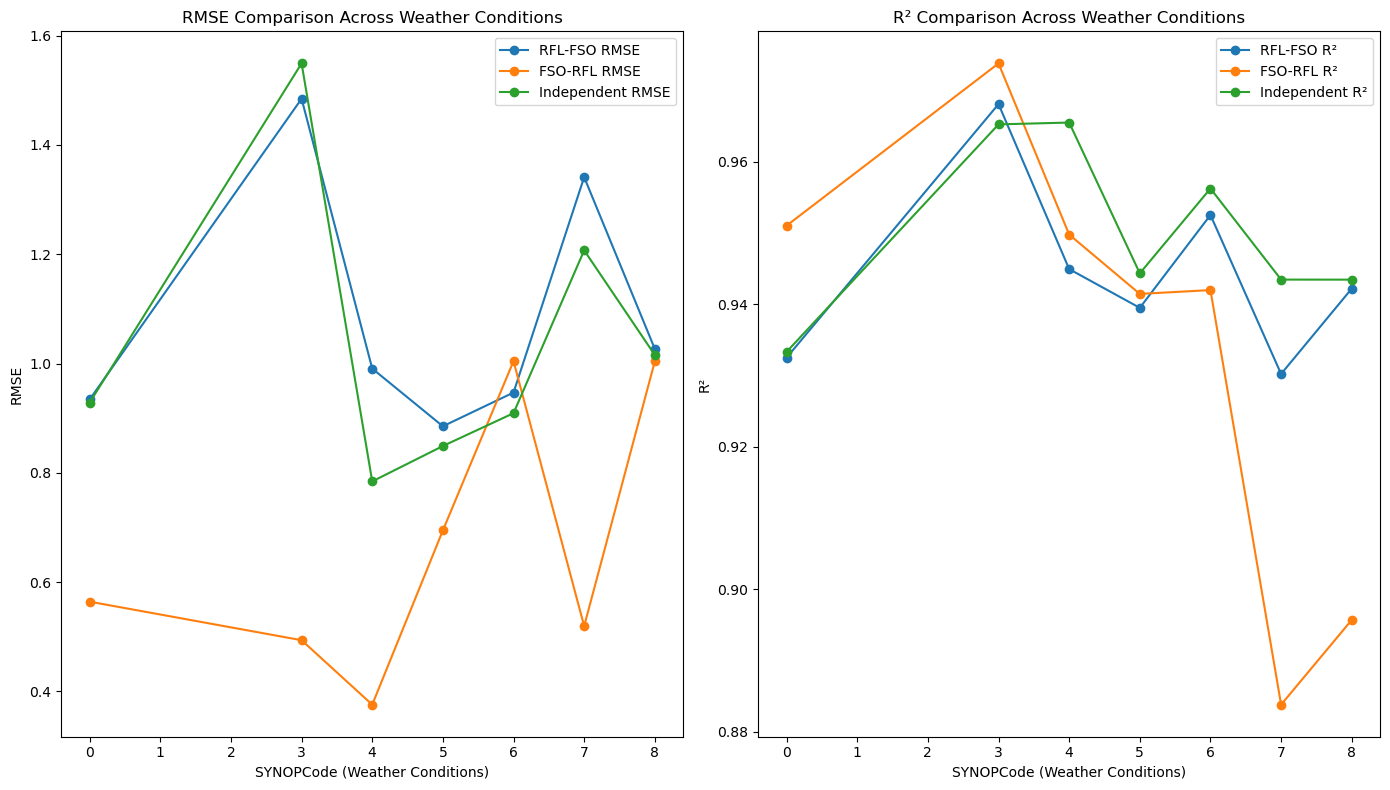

In [ ]:
# define function to calculate rmse and r2
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# initialize dict 
metrics = {
    'SYNOPCode': [],
    'RFL-FSO_RMSE': [],
    'RFL-FSO_R²': [],
    'FSO-RFL_RMSE': [],
    'FSO-RFL_R²': [],
    'Independent_RMSE': [],
    'Independent_R²': []
}

# calculate by different synopcode
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    
    # RFL-FSO model
    rmse_rfl_fso, r2_rfl_fso = calculate_metrics(subset['y_FSO_test'], subset['y_pred_FSO_2'])
    
    # FSO-RFL model
    rmse_fso_rfl, r2_fso_rfl = calculate_metrics(subset['y_RFL_test'], subset['RFL_pred_1'])
    
    # independent model
    rmse_independent, r2_independent = calculate_metrics(subset['y_FSO_test'], subset['FSO_pred_1'])
    
    # save result
    metrics['SYNOPCode'].append(synop_code)
    metrics['RFL-FSO_RMSE'].append(rmse_rfl_fso)
    metrics['RFL-FSO_R²'].append(r2_rfl_fso)
    metrics['FSO-RFL_RMSE'].append(rmse_fso_rfl)
    metrics['FSO-RFL_R²'].append(r2_fso_rfl)
    metrics['Independent_RMSE'].append(rmse_independent)
    metrics['Independent_R²'].append(r2_independent)

# transform result to dataframe
metrics_df = pd.DataFrame(metrics)

# print result
print(metrics_df)

# sort by synopcode
metrics_df_sorted = metrics_df.sort_values(by='SYNOPCode')

# plotting
plt.figure(figsize=(14, 8))

# plot RMSE 
plt.subplot(1, 2, 1)
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['RFL-FSO_RMSE'], label='RFL-FSO RMSE', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['FSO-RFL_RMSE'], label='FSO-RFL RMSE', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_RMSE'], label='Independent RMSE', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Weather Conditions')
plt.legend()

# plot r2
plt.subplot(1, 2, 2)
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['RFL-FSO_R²'], label='RFL-FSO R2', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['FSO-RFL_R²'], label='FSO-RFL R2', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_R²'], label='Independent R2', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('R2')
plt.title('R2 Comparison Across Weather Conditions')
plt.legend()

plt.tight_layout()
plt.show()